<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    

<br>

<div style="font-weight: 700; font-size: 25px;"> [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course </div>

<br>

Auteurs: [Maria Sumarokova](https://www.linkedin.com/in/mariya-sumarokova-230b4054/) et [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Traduit et édité par Gleb Filatov, Aleksey Kiselev, [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/) et [Ousmane Cissé](https://github.com/oussou-dev). Tout le contenu est distribué sous la licence [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).</center>

<div style="font-weight: 700; font-size: 25px;"> <center> Mission n ° 3 (démo) </center></div>
    
<br>    
    
<div style="font-weight: 700; font-size: 20px;"> <center> Arbres de décision avec une "tâche jouet" (toy task) et le jeu de données UCI Adult </center></div>

    

La même mission sur [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + la [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution). Complétez les réponses dans le [formulaire Web](https://docs.google.com/forms/d/1wfWYYoqXTkZNOPy1wpewACXaj2MZjBdLOL58htGWYBA/edit).

Commençons par charger toutes les bibliothèques nécessaires:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from ipywidgets import Image
from io import StringIO
import pydotplus #pip install pydotplus

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Partie 1. Jeu de données de jouet "Will They? Won't They?"

Votre objectif est de comprendre le fonctionnement des arbres de décision en résolvant un problème de jouet. Bien qu'un seul arbre de décision ne donne pas de résultats remarquables, d'autres algorithmes performants, tels que le boosting de gradient et les forêts aléatoires, sont basés sur la même idée. C'est pourquoi connaître le fonctionnement des arbres de décision peut être utile.

Nous allons passer à un exemple jouet de classification binaire - La personne A décide si elle ira à un deuxième rendez-vous avec la personne B. Cela dépendra de son apparence, de son éloquence, de sa consommation d’alcool (par exemple) et de combien d'argent elle a dépensé lors du premier rendez-vous

#### Création du jeu de données

In [2]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Looks', 'Alcoholic_beverage','Eloquence','Money_spent']

#### Données d'entraînement

In [4]:
df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                         'repulsive', 'repulsive', 'handsome'] 
df_train['Alcoholic_beverage'] = ['yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                                   'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                                  'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


#### Données de test

In [5]:
df_test = {}
df_test['Looks'] = ['handsome', 'handsome', 'repulsive'] 
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_high,Money_spent_lots,Eloquence_average,Looks_handsome,Money_spent_little,Looks_repulsive
0,0,1,1,1,0,1,0,0
1,0,1,0,0,0,1,1,0
2,1,0,0,1,1,1,0,0
3,1,0,0,0,1,0,1,1
4,0,1,0,1,0,0,0,1
5,0,1,1,1,0,0,0,1
6,0,1,0,1,1,1,0,0


In [7]:
df_test

,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_high,Money_spent_lots,Eloquence_average,Looks_handsome,Money_spent_little,Looks_repulsive
0,1,0,0,1,1,1,0,0
1,0,1,1,0,0,1,1,0
2,0,1,0,1,1,0,0,1


#### Dessinez un arbre de décision (à la main ou dans n’importe quel éditeur graphique) pour cet ensemble de données. Facultativement, vous pouvez également mettre en œuvre la construction de l'arbre et le dessiner ici.

1\. Quelle est l'entropie $S_0$ du système initial? Par états du système, nous entendons les valeurs de la caractéristique binaire "Will_go" - 0 ou 1 - deux états au total.

In [8]:
# you code here

2 \. Partitionnons les données par la caractéristique "Looks_handsome". Qu'est-ce que l'entropie $S_1$ du groupe de gauche - celle avec "Looks_handsome". Quelle est l'entropie $S_2$ dans le groupe opposé? Quel est le gain d’information (IG) si on considère une telle partition?

In [9]:
# you code here

#### Entraînez un arbre de décision en utilisant sklearn sur les données d'apprentissage. Vous pouvez choisir n'importe quelle profondeur pour l'arbre.

In [10]:
# you code here

#### Supplément : affichez l'arbre résultant en utilisant graphviz. Vous pouvez utiliser pydot ou le [service Web](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.

In [11]:
# you code here

### Partie 2. Fonctions de calcul d'entropie et de gain d'information.

Prenons l'exemple d'échauffement suivant: nous avons 9 balles bleues et 11 balles jaunes. Laissez la balle avoir l'étiquette **1** si elle est bleue, **0** sinon.

In [12]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

<img src="https://habrastorage.org/webt/mu/vl/mt/muvlmtd2njeqf18trbldenpqvnm.png">

Ensuite, divisez les balles en deux groupes:

<img src="https://habrastorage.org/webt/bd/aq/5w/bdaq5wi3c4feezaexponvin8wmo.png">

In [13]:
# two groups
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 blue and 6 yellow

#### Implémenter une fonction pour calculer l'entropie de Shannon

In [14]:
def entropy(a_list):
    # you code here
    pass

Quelques tests

In [15]:
print(entropy(balls)) # 9 blue и 11 yellow
print(entropy(balls_left)) # 8 blue и 5 yellow
print(entropy(balls_right)) # 1 blue и 6 yellow
print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided die

None
None
None
None


3 \. Quelle est l'entropie de l'état donné par la liste **balls_left**?

4 \. Quelle est l'entropie d'un dé non pipé? (où nous considérons un dé comme un système à 6 états également probables)?

In [16]:
# calcul du gain d'information
def information_gain(root, left, right):
    ''' root - initial data, left and right - two partitions of initial data'''
    
    # you code here
    pass

5 \. Quel est l’information que procure le fractionnement de l’ensemble de données initial en **balls_left** et **balls_right**?

In [17]:
def best_feature_to_split(X, y):
    '''Outputs information gain when splitting on best feature'''
    
    # you code here
    pass

#### Optionnel:
- Implémenter un algorithme de construction d'arbre de décision en appelant **best_feature_to_split** de manière récursive
- Tracer l'arbre résultant

### Part 3. Le jeu de données "Adult"

**Description du jeu de données:**

[Jeu de données](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) UCI Adulte (inutile de le télécharger, nous en avons une copie dans le référentiel des cours): classifiez les personnes qui utilisent des données démographiques - qu’ils gagnent plus de 50 000 dollars par an ou non.

Description des caractéristiques :

- **Age** - caractéristique continue
- **Workclass** - caractéristique continue
- **fnlwgt** - poids final de l'objet, caractéristique continue
- **Education** - caractéristique catégorielle
- **Education_Num** - nombre d'années d'études, caractéristique continue
- **Martial_Status** - caractéristique catégorielle
- **Profession** - caractéristique catégorielle
- **Relation** - caractéristique catégorielle
- **Race** - caractéristique catégorielle
- **Sexe** - caractéristique catégorielle
- **Capital_Gain** - caractéristique continue
- **Capital_Loss** - caractéristique continue
- **Hours_per_week** - caractéristique continue
- **Pays** - caractéristique catégorielle

**Target** - Niveau de revenus, caractéristique catégorielle (binaire).

**Lecture des données d'entraînement et de test**

In [18]:
data_train = pd.read_csv('../input/adult_train.csv')

In [19]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [20]:
data_test = pd.read_csv('../input/adult_test.csv')

In [21]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [22]:
# nécessaire pour supprimer les lignes avec des étiquettes incorrectes dans l'ensemble de données de test
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# encoder la variable cible en entier
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

**Analyse "primaire" des données**

In [23]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

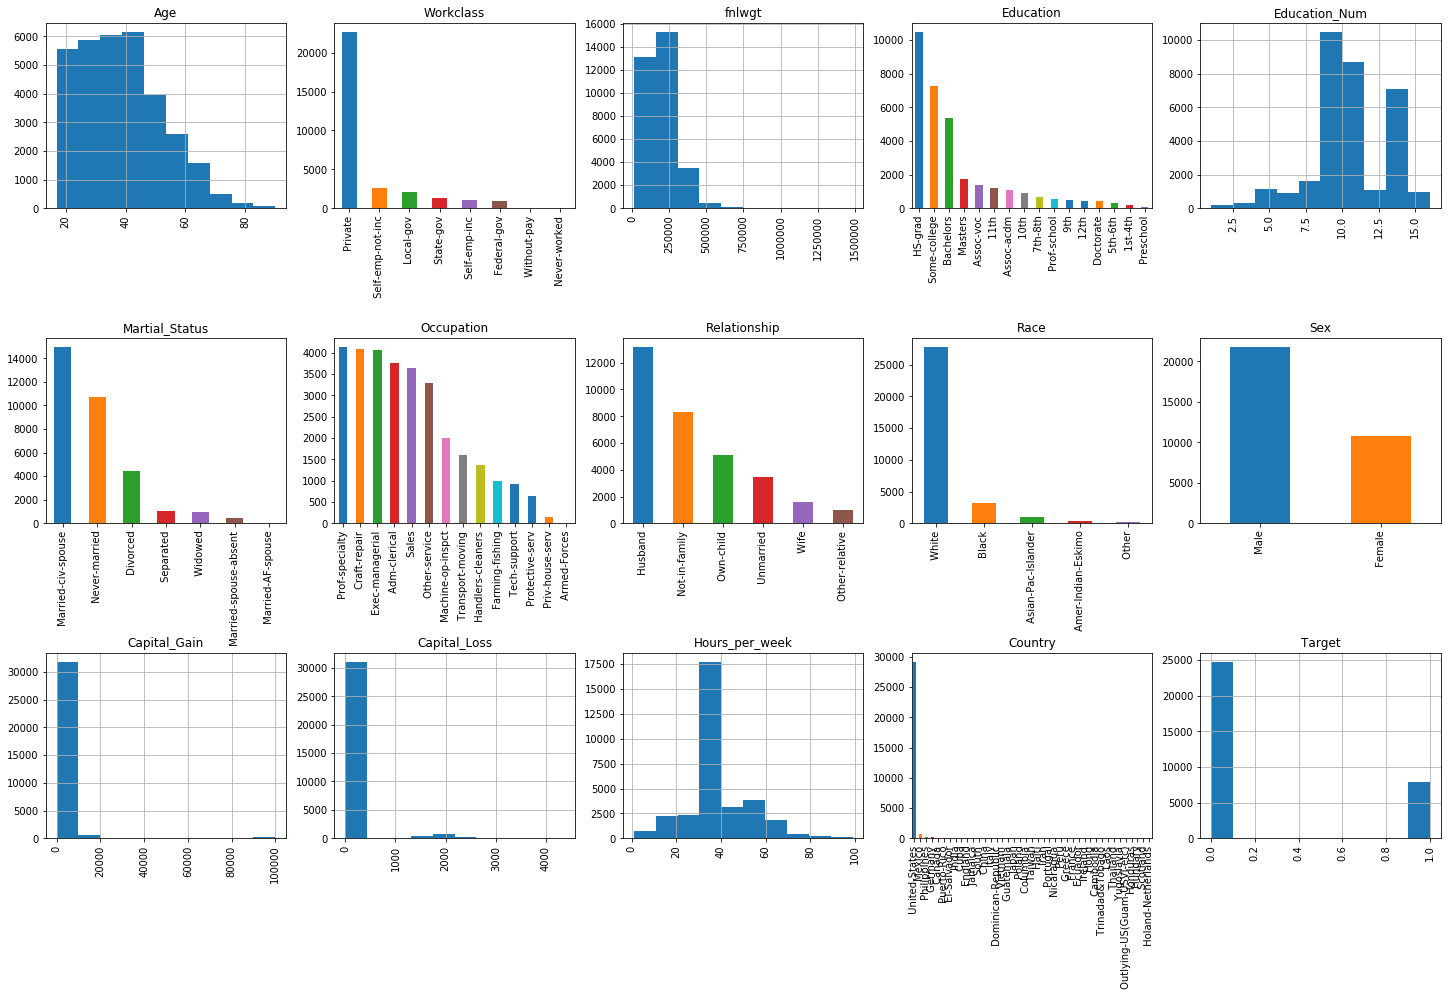

In [25]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

**Vérification des types de données**

In [26]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [27]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target              int64
dtype: object

Comme nous le voyons, dans les données de test, l’âge est traité comme un type **objet**. Nous devons résoudre ce problème.

In [28]:
data_test['Age'] = data_test['Age'].astype(int)

Nous allons également transtyper (convertir) tous les éléments **float** en types **int** pour que les types restent cohérents entre nos données d'entraînement et de test.

In [29]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

**Complétez les données manquantes pour les caractéristiques continues avec leurs valeurs médianes, pour les caractéristiques catégorielles avec leur mode.**

In [30]:
# choisir des caractéristiques catégorielles et continues à partir des données

categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [31]:
# nous voyons quelques valeurs manquantes
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int64
Workclass         30725 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education_Num     32561 non-null int64
Martial_Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
Capital_Gain      32561 non-null int64
Capital_Loss      32561 non-null int64
Hours_per_week    32561 non-null int64
Country           31978 non-null object
Target            32561 non-null int64
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [32]:
# compléter (remplacer) les données manquantes

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)
    
for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [33]:
# plus de valeurs manquantes
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int64
Workclass         32561 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education_Num     32561 non-null int64
Martial_Status    32561 non-null object
Occupation        32561 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
Capital_Gain      32561 non-null int64
Capital_Loss      32561 non-null int64
Hours_per_week    32561 non-null int64
Country           32561 non-null object
Target            32561 non-null int64
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


Nous allons coder des données factices pour certaines caractéristiques catégorielles: **Workclass**, **Education**, **Martial_Status**, **Profession**, **Relationship**, **Race**, **Sex**, **Country**. Cela peut être fait via la méthode pandas **get_dummies**

In [34]:
data_train = pd.concat([data_train[numerical_columns],
    pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
    pd.get_dummies(data_test[categorical_columns])], axis=1)

In [35]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [36]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

**Il n'y a pas Holland (Hollande, Pays-bas) dans les données de test. Créer une nouvelle caractéristique de valeur zéro.**

In [37]:
data_test['Country_ Holand-Netherlands'] = 0

In [38]:
set(data_train.columns) - set(data_test.columns)

set()

In [39]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,Education_ 7th-8th,Education_ 9th,Education_ Assoc-acdm,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Martial_Status_ Divorced,Martial_Status_ Married-AF-spouse,Martial_Status_ Married-civ-spouse,Martial_Status_ Married-spouse-absent,Martial_Status_ Never-married,Martial_Status_ Separated,Martial_Status_ Widowed,Occupation_ Adm-clerical,Occupation_ Armed-Forces,...,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,Country_ Dominican-Republic,Country_ Ecuador,Country_ El-Salvador,Country_ England,Country_ France,Country_ Germany,Country_ Greece,Country_ Guatemala,Country_ Haiti,Country_ Holand-Netherlands,Country_ Honduras,Country_ Hong,Country_ Hungary,Country_ India,Country_ Iran,Country_ Ireland,Country_ Italy,Country_ Jamaica,Country_ Japan,Country_ Laos,Country_ Mexico,Country_ Nicaragua,Country_ Outlying-US(Guam-USVI-etc),Country_ Peru,Country_ Philippines,Country_ Poland,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [40]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,Education_ 7th-8th,Education_ 9th,Education_ Assoc-acdm,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Martial_Status_ Divorced,Martial_Status_ Married-AF-spouse,Martial_Status_ Married-civ-spouse,Martial_Status_ Married-spouse-absent,Martial_Status_ Never-married,Martial_Status_ Separated,Martial_Status_ Widowed,Occupation_ Adm-clerical,Occupation_ Armed-Forces,...,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,Country_ Dominican-Republic,Country_ Ecuador,Country_ El-Salvador,Country_ England,Country_ France,Country_ Germany,Country_ Greece,Country_ Guatemala,Country_ Haiti,Country_ Honduras,Country_ Hong,Country_ Hungary,Country_ India,Country_ Iran,Country_ Ireland,Country_ Italy,Country_ Jamaica,Country_ Japan,Country_ Laos,Country_ Mexico,Country_ Nicaragua,Country_ Outlying-US(Guam-USVI-etc),Country_ Peru,Country_ Philippines,Country_ Poland,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [41]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

#### 3.1 Arbre de décision sans réglage des paramètres

Entraînez un arbre de décision **(DecisionTreeClassifier) ​​** avec une profondeur maximale de 3, et évaluez la métrique de précision des données de test. Utilisez le paramètre **random_state = 17** pour la reproductibilité des résultats.

In [42]:
# you code here
# tree = 
# tree.fit

Faites une prédiction avec le modèle formé sur les données de test.

In [43]:
# you code here
# tree_predictions = tree.predict 

In [44]:
# you code here
# accuracy_score 

6 \. Quelle est la précision des données de test d'un arbre de décision avec une profondeur d'arbre maximale de 3 et **random_state = 17**?

#### 3.2 Arbre de décision avec réglage des paramètres

Entraînez un arbre de décision **(DecisionTreeClassifier, random_state = 17).** Recherchez la profondeur maximale optimale à l'aide de la validation croisée par 5-fold **(GridSearchCV)**.

In [45]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV # you code here                     

locally_best_tree.fit; # you code here 

Entraînez un arbre de décision avec une profondeur maximale de 9 (il s'agit du meilleur **max_depth** dans mon cas) et calculez la précision des données de tests. Utilisez le paramètre **random_state = 17** pour la reproductibilité.

In [46]:
# you code here 
# tuned_tree = 
# tuned_tree.fit 
# tuned_tree_predictions = tuned_tree.predict
# accuracy_score

7\. Quelle est la précision de l'ensemble des données de tests d'un arbre de décision avec une profondeur maximale de 9 et **random_state = 17**?

#### 3.3 (Facultatif) Forêt aléatoire sans réglage de paramètre

Jetons un coup d'œil aux conférences à venir et essayons d'utiliser une forêt aléatoire pour notre tâche. Pour le moment, vous pouvez imaginer une forêt aléatoire comme un groupe d’arbres de décision formés sur des sous-ensembles légèrement différents des données d’entraînement.

Entraîner une forêt aléatoire **(RandomForestClassifier)**. Définissez le nombre d'arbres sur 100 et utilisez **random_state = 17**.

In [47]:
# you code here 
# rf = 
# rf.fit # you code here 

Faites des prévisions pour les données de test et évaluez leur précision.

In [48]:
# you code here 

#### 3.4 (Facultatif) Forêt aléatoire avec réglage des paramètres

Entraîner une forêt aléatoire **(RandomForestClassifier)**. Réglez la profondeur maximale et le nombre maximal de caractéristiques pour chaque arbre à l’aide de **GridSearchCV**.

In [49]:
# forest_params = {'max_depth': range(10, 21),
#                 'max_features': range(5, 105, 20)}

# locally_best_forest = GridSearchCV # you code here 

# locally_best_forest.fit # you code here 

Faites des prévisions pour les données de test et évaluez leur précision.

In [50]:
# you code here 